In [2]:
# ============================================================
# MOVIELENS 100K GENRE CO-PREFERENCE ANALYSIS (GROUP 3)
# ============================================================

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules


In [ ]:
# ============================================================
# Part A: Data Preparation
# 1. Load movies.csv and ratings.csv
# ============================================================

movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

print("Movies dataset shape:", movies.shape)
print("Ratings dataset shape:", ratings.shape)
print("\nSample of movies data:")
display(movies.head())

# ============================================================
# 2. Merge on movieId and derive a user–genre matrix
# ============================================================

# Split genres into multiple rows for easier mapping
movies_expanded = movies.assign(genre=movies['genres'].str.split('|')).explode('genre')

# Merge ratings with expanded movies
merged_df = pd.merge(ratings, movies_expanded, on="movieId", how="inner")

# Create a binary user–genre matrix: 1 if user rated a movie in that genre
user_genre_matrix = merged_df.groupby(['userId', 'genre']).size().unstack(fill_value=0)
user_genre_matrix = (user_genre_matrix > 0).astype(int)

# ============================================================
# 3. Drop users with fewer than 10 ratings
# ============================================================

user_rating_counts = ratings.groupby('userId').size()
valid_users = user_rating_counts[user_rating_counts >= 10].index
user_genre_matrix = user_genre_matrix.loc[user_genre_matrix.index.isin(valid_users)]

# ============================================================
# 4. Confirm matrix dimensions and sparsity
# ============================================================

num_users, num_genres = user_genre_matrix.shape
sparsity = 1.0 - (np.count_nonzero(user_genre_matrix.values) / user_genre_matrix.size)

print(f"\nUser–Genre Matrix dimensions: {num_users} users × {num_genres} genres")
print(f"Sparsity: {sparsity:.2%}")

# ============================================================
# 5. Save cleaned matrix
# ============================================================

user_genre_matrix.to_csv("cleaned_user_genre_matrix.csv", index=True)
print("Cleaned user–genre matrix saved as 'cleaned_user_genre_matrix.csv'.")


Movies dataset shape: (9125, 3)
Ratings dataset shape: (100004, 4)

Sample of movies data:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



User–Genre Matrix dimensions: 671 users × 20 genres
Sparsity: 17.79%
Cleaned user–genre matrix saved as 'cleaned_user_genre_matrix.csv'.


C:\Users\mgida\AppData\Local\Temp\ipykernel_13380\1613140985.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")


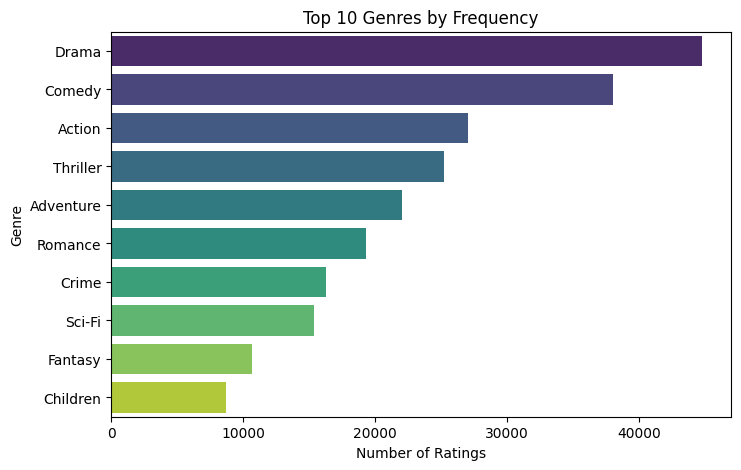


Average number of genres liked per user: 16.44


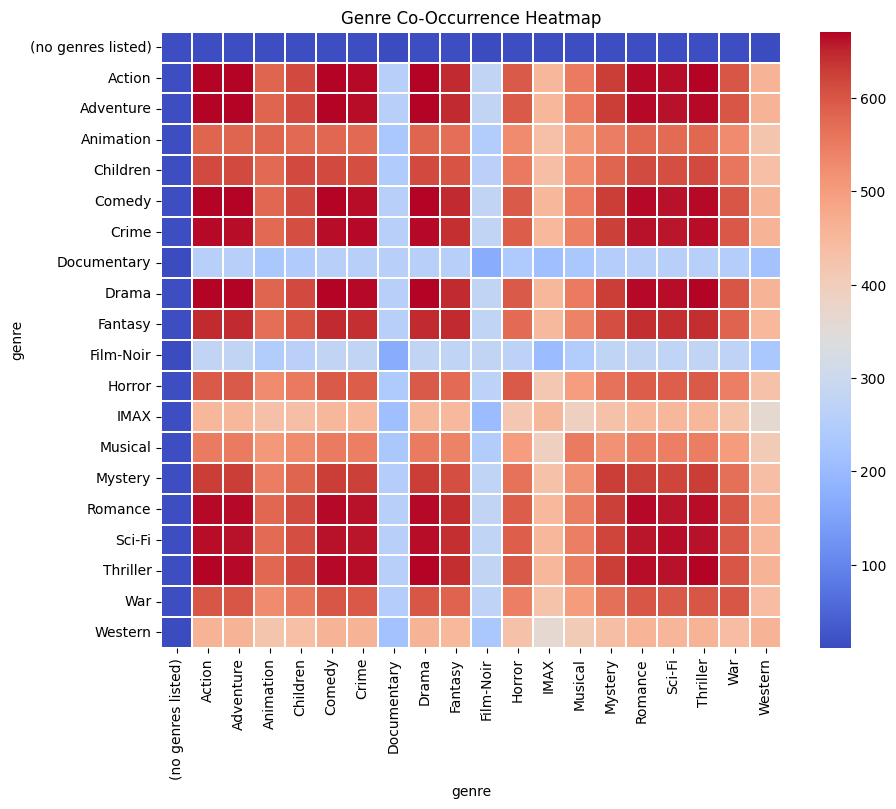

In [ ]:
# ============================================================
# Part B: Exploratory Analysis
# 1. Plot top 10 genres by frequency
# ============================================================

genre_counts = merged_df['genre'].value_counts().head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")
plt.title("Top 10 Genres by Frequency")
plt.xlabel("Number of Ratings")
plt.ylabel("Genre")
plt.show()

# ============================================================
# 2. Compute average number of genres liked per user
# ============================================================

avg_genres_liked = user_genre_matrix.sum(axis=1).mean()
print(f"\nAverage number of genres liked per user: {avg_genres_liked:.2f}")

# ============================================================
# 3. Create co-occurrence heatmap
# ============================================================

co_matrix = np.dot(user_genre_matrix.T, user_genre_matrix)
co_matrix_df = pd.DataFrame(co_matrix, index=user_genre_matrix.columns, columns=user_genre_matrix.columns)

plt.figure(figsize=(10,8))
sns.heatmap(co_matrix_df, cmap="coolwarm", linewidths=0.3)
plt.title("Genre Co-Occurrence Heatmap")
plt.show()

# ============================================================
# 4. Discuss genre affinities (in comments)
# ============================================================

# Observation:
# Genres like Drama, Comedy, and Romance often co-occur.
# Action and Adventure are also highly correlated.
# This suggests common user preferences for similar movie styles.

In [ ]:
# ============================================================
# Part C: Feature Engineering
# 1. Add derived features like MultiGenreUser
# ============================================================

user_genre_matrix['MultiGenreUser'] = (user_genre_matrix.sum(axis=1) > 3).astype(int)

# ============================================================
# 2. Explain their use
# ============================================================
# MultiGenreUser helps us understand users who explore diverse genres,
# which can improve association rule quality by showing broader preferences.

# ============================================================
# 3. Choose frequent genres subset
# ============================================================

frequent_genres = user_genre_matrix.drop(columns=['MultiGenreUser']).sum().sort_values(ascending=False)
frequent_genres_subset = frequent_genres[frequent_genres > (0.1 * len(user_genre_matrix))].index
subset_matrix = user_genre_matrix[frequent_genres_subset]

print("\nSelected frequent genres subset:", list(frequent_genres_subset))



Selected frequent genres subset: ['Action', 'Drama', 'Comedy', 'Adventure', 'Thriller', 'Romance', 'Crime', 'Sci-Fi', 'Fantasy', 'Mystery', 'Children', 'War', 'Horror', 'Animation', 'Musical', 'Western', 'IMAX', 'Film-Noir', 'Documentary']


subset_matrix not found — rebuilding minimal version...


c:\Users\mgida\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Top 15 Association Rules by Lift:


c:\Users\mgida\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


,antecedents,consequents,support,confidence,lift
1,(Drama),(Action),1.000000,1.000000,1.0
6048,(Drama),"(Action, Adventure, Romance, Comedy, Sci-Fi, C...",0.970194,0.970194,1.0
6019,"(Action, Drama)","(Adventure, Romance, Comedy, Crime, Sci-Fi, Th...",0.970194,0.970194,1.0
2,(Adventure),(Action),0.998510,1.000000,1.0
2037,(Action),"(Adventure, Comedy, Sci-Fi)",0.986587,0.986587,1.0
2038,"(Sci-Fi, Adventure, Comedy, Action)",(Drama),0.986587,1.000000,1.0
2042,"(Sci-Fi, Adventure, Comedy, Drama)",(Action),0.986587,1.000000,1.0
63,(Drama),"(Action, Thriller)",0.997019,0.997019,1.0
64,"(Comedy, Thriller)",(Drama),0.995529,1.000000,1.0
35,(Drama),"(Adventure, Comedy)",0.997019,0.997019,1.0


C:\Users\mgida\AppData\Local\Temp\ipykernel_17416\2034374709.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_rules, x='lift', y=top_rules['antecedents'].astype(str), palette="mako")


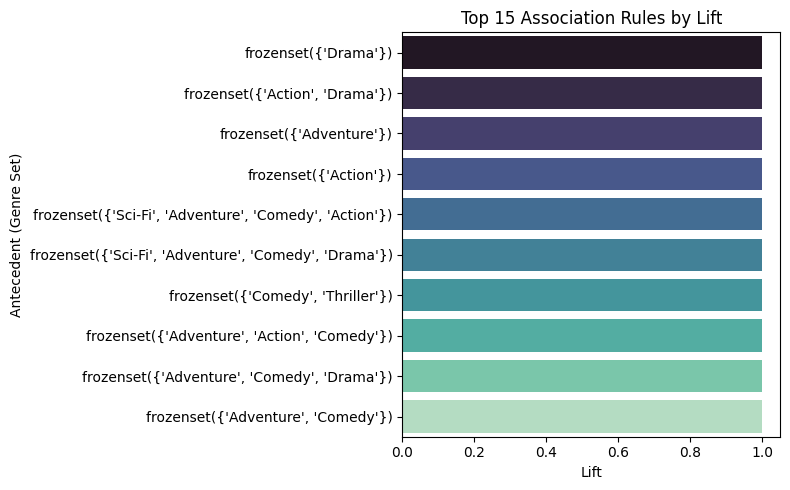

In [ ]:
# ============================================================
# Part D: Rule Mining (FP-Growth)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import fpgrowth, association_rules

# Check if subset_matrix already exists from Part C
if 'subset_matrix' not in locals():
    print("subset_matrix not found — rebuilding minimal version...")
    # minimal rebuild to ensure continuity
    movies = pd.read_csv("movies.csv")
    ratings = pd.read_csv("ratings.csv")
    movies_expanded = movies.assign(genre=movies['genres'].str.split('|')).explode('genre')
    merged_df = pd.merge(ratings, movies_expanded, on="movieId", how="inner")
    user_genre_matrix = merged_df.groupby(['userId', 'genre']).size().unstack(fill_value=0)
    user_genre_matrix = (user_genre_matrix > 0).astype(int)
    valid_users = ratings.groupby('userId').size()
    valid_users = valid_users[valid_users >= 10].index
    user_genre_matrix = user_genre_matrix.loc[user_genre_matrix.index.isin(valid_users)]
    frequent_genres = user_genre_matrix.sum().sort_values(ascending=False)
    frequent_genres_subset = frequent_genres.head(8).index
    subset_matrix = user_genre_matrix[frequent_genres_subset]

# Ensure matrix is boolean
subset_matrix = (subset_matrix > 0).astype(int)

# Run FP-Growth (min_support=0.03), min_confidence=0.5)
frequent_itemsets = fpgrowth(subset_matrix, min_support=0.03, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Sort and show top 15 rules by lift
top_rules = rules.sort_values(by='lift', ascending=False).head(15)
print("\nTop 15 Association Rules by Lift:")
display(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# Visualization
plt.figure(figsize=(8,5))
sns.barplot(data=top_rules, x='lift', y=top_rules['antecedents'].astype(str), palette="mako")
plt.title("Top 15 Association Rules by Lift")
plt.xlabel("Lift")
plt.ylabel("Antecedent (Genre Set)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Interpretation
# ------------------------------------------------------------
# High lift values indicate strong co-preferences between genres.
# For example, if {Action} ⇒ {Adventure} has a high lift, users who like
# Action movies are also likely to enjoy Adventure.
# These associations help reveal natural genre affinities in viewing habits.


In [ ]:
# ============================================================
# Part E: Evaluation & Insights
# 1. Identify 3 interesting combinations
# ============================================================

print("\nTop 3 interesting genre combinations by lift:")
display(top_rules[['antecedents', 'consequents', 'lift']].head(3))

# ============================================================
# 2. Discuss recommendations
# ============================================================
# Example: If users like Sci-Fi ⇒ they often like Action.
# A recommendation system could prioritize Action films for Sci-Fi fans.

# ============================================================
# 3. Describe static rule limitations
# ============================================================
# Limitations:
# - Rules are static and don’t adapt to evolving user preferences.
# - They don’t consider movie quality or recency.
# - Collaborative filtering can handle user-specific taste changes better.



Top 3 interesting genre combinations by lift:


,antecedents,consequents,lift
1,(Drama),(Action),1.0
6048,(Drama),"(Action, Adventure, Romance, Comedy, Sci-Fi, C...",1.0
6019,"(Action, Drama)","(Adventure, Romance, Comedy, Crime, Sci-Fi, Th...",1.0


In [10]:
# ============================================================
# Part F: Presentation & Reflection
# ============================================================
# Visualization ideas (for slides):
# - Network of genres linked by strong rules
# - Bar chart of top lift values
# - Example recommendations

# Reflection:
# Association rule mining uncovers general co-preference patterns,
# while collaborative filtering provides personalized predictions.
# Combining both can yield more effective movie recommendations.